In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

### Request HPC Resources

In [3]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='190GB',
    walltime='03:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=4)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=177G
#SBATCH -t 03:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.96:39335 --name dummy-name --nthreads 36 --memory-limit 176.95GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.96:39335,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load in data

In [6]:
expt_datafiles = collect_tracer_files(model="CM4Xp125")
del expt_datafiles["spinup"]
expt_datafiles.keys()

dict_keys(['forced', 'control'])

In [7]:
def volume_weighted_average(ds):
    weights = (ds.thkcello * ds.areacello * ds.wet).where(ds.wet > 0)
    weighted_ds = (ds.drop_vars(["thkcello"]) * weights).sum(["xh", "yh"], skipna = True) / weights.sum(["xh", "yh"], skipna = True)
    return weighted_ds

In [9]:
latmin, latmax = -91, -50 #true max is 20 degrees max because the mediterranean is weird (nned to show henri)

ds_zon_ts_dict = {}
for key in expt_datafiles.keys():
    datafiles = expt_datafiles[key]
    ds_zons = []
    for (t, file) in enumerate(datafiles[20:]): 
        if t % 5 == 0:
            print(key, ":", file)
    
        ds = read_tracer_and_zos_from_budget(file)
        
        ds["rho2"] = ds.sigma2_l * xr.where(ds.thkcello.fillna(0.0) > 0.0, 1, 0) 
        ds["rho2"] = ds["rho2"].where(ds["rho2"] > 0)
        ds["rho2"].attrs.update({
        "cell_methods": ds["thetao"].attrs["cell_methods"],
        "standard_name": "sea_water_potential_density",
        "units": "kg / m^3",
        "description": "Potential Density references to 2000 dbar"
        })
        
        ds_remap = remap_sigma_to_depth(ds.where(ds.wet > 0))

        lat_mask = (ds_remap.geolat > latmin) * (ds_remap.geolat < latmax)
        ds_remap = ds_remap.where(lat_mask)
        ds_remap = update_thermodynamic_variables(ds_remap, zname = "z_l")
        ds_avg = volume_weighted_average(ds_remap).compute()

        ds_zons += [1 * ds_avg]

    ds_zon_ts_dict[key] = xr.concat(ds_zons, dim = "time").sortby("time")
    
ds_zon_ts_list = [
    ds_zon_ts_dict[dkey].expand_dims(exp=[dkey]) 
    for dkey in ds_zon_ts_dict.keys()
]
combined_zon_ts_ds = xr.concat(ds_zon_ts_list, dim="exp")
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/"
savename = savedir + f"SO_Tracer_Hov_on_Z.nc"
print(f"Saving {key} to", ": ", savename)
combined_zon_ts_ds.to_netcdf(savename)

forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_historical_tracers_sigma2_1950-1954.zarr
forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_historical_tracers_sigma2_1975-1979.zarr
forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_historical_tracers_sigma2_2000-2004.zarr
forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_ssp585_tracers_sigma2_2025-2029.zarr
forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_ssp585_tracers_sigma2_2050-2054.zarr
forced : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_ssp585_tracers_sigma2_2075-2079.zarr
control : /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/tracers_sigma2_1p5/CM4Xp125_piControl_tracers_sigma

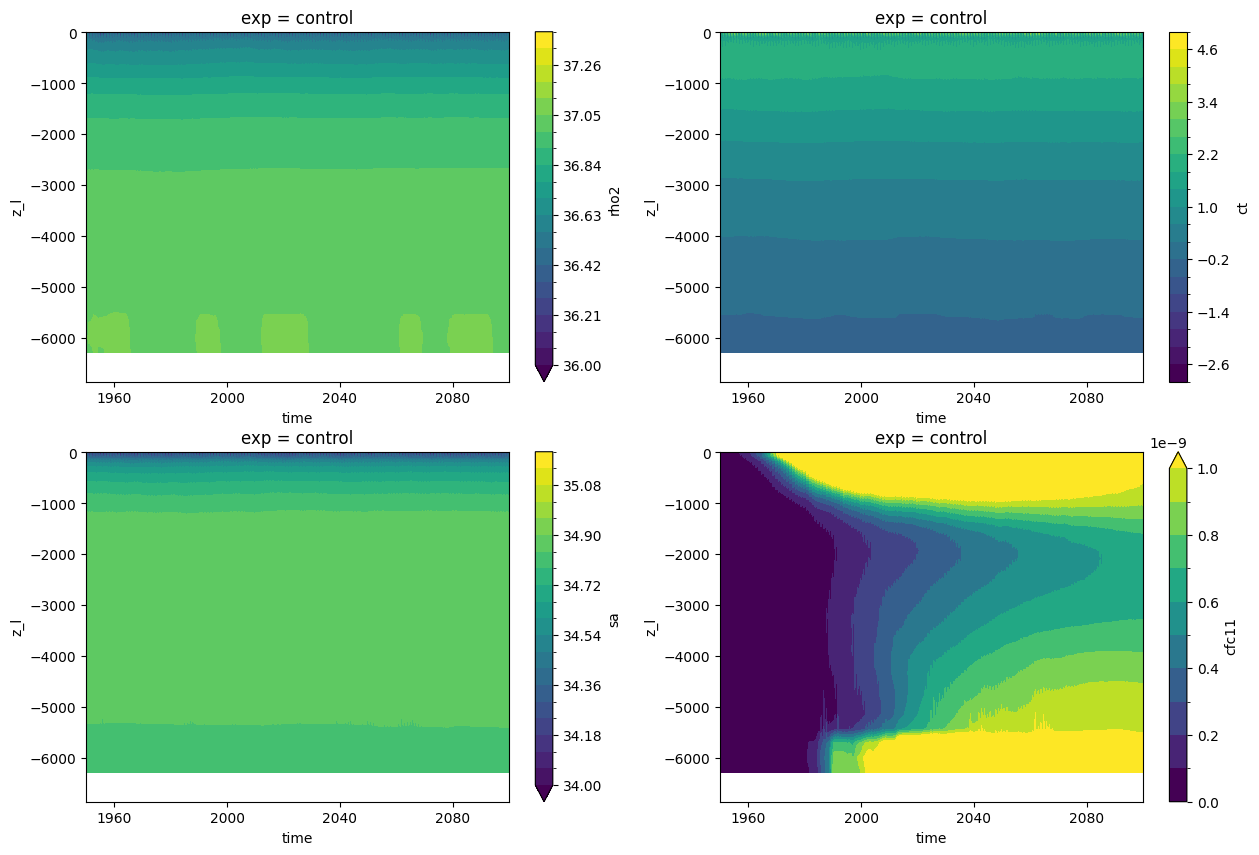

In [12]:
ds_hov_ts_tmp = combined_zon_ts_ds.sel(exp = "control")

fig, axes = plt.subplots(2, 2, figsize = (15, 10))
ax = axes.flatten()
ds_hov_ts_tmp["rho2"].T.plot.contourf(ax = ax[0],y = "z_l", x = "time", levels = 21, vmin = 36, vmax = 37.4)
ds_hov_ts_tmp["ct"].T.plot.contourf(ax = ax[1],y = "z_l", x = "time", levels = 21, vmax = 5, vmin = -3)
ds_hov_ts_tmp["sa"].T.plot.contourf(ax = ax[2],y = "z_l", x = "time", levels = 21, vmax = 35.2, vmin = 34)
ds_hov_ts_tmp["cfc11"].T.plot.contourf(ax = ax[3], y = "z_l", x = "time", levels = 11, vmax = 1e-9)

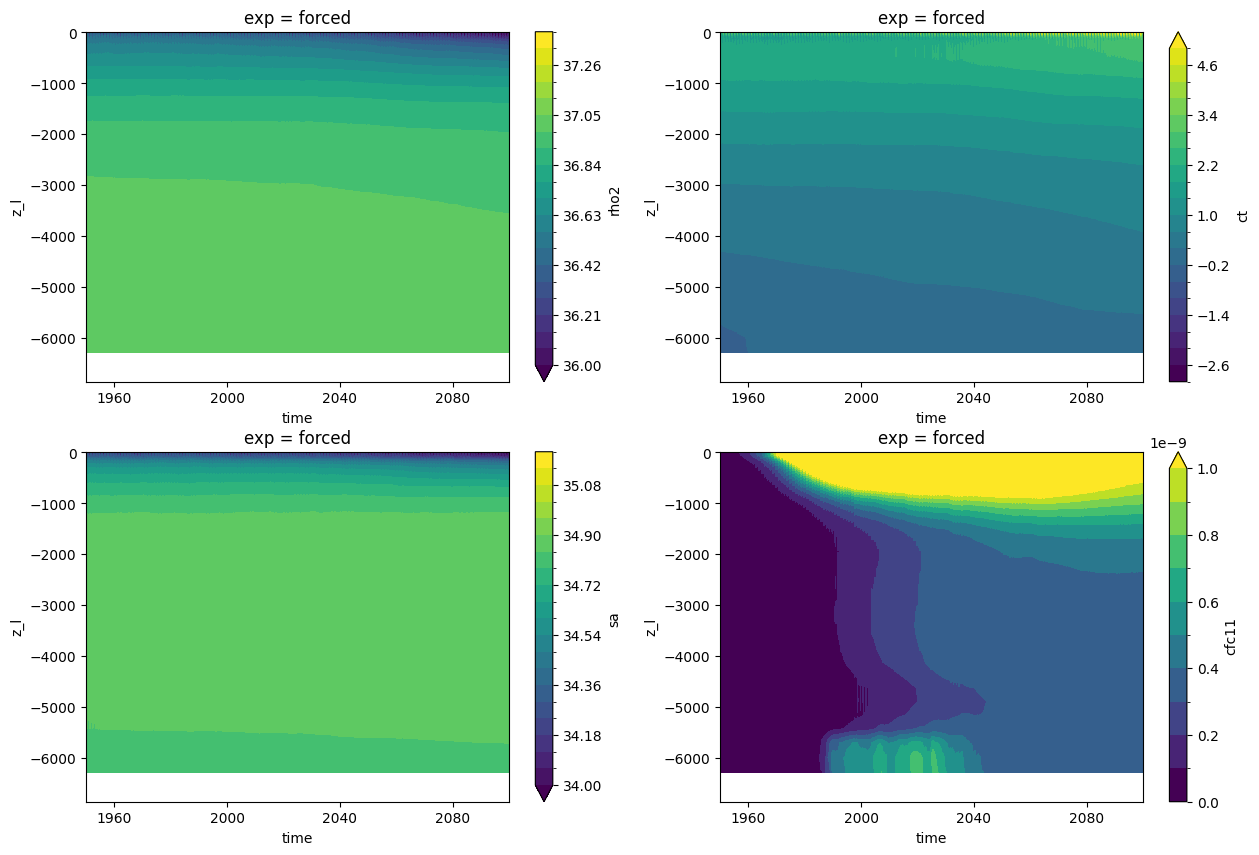

In [13]:
ds_hov_ts_tmp = combined_zon_ts_ds.sel(exp = "forced")

fig, axes = plt.subplots(2, 2, figsize = (15, 10))
ax = axes.flatten()
ds_hov_ts_tmp["rho2"].T.plot.contourf(ax = ax[0],y = "z_l", x = "time", levels = 21, vmin = 36, vmax = 37.4)
ds_hov_ts_tmp["ct"].T.plot.contourf(ax = ax[1],y = "z_l", x = "time", levels = 21, vmax = 5, vmin = -3)
ds_hov_ts_tmp["sa"].T.plot.contourf(ax = ax[2],y = "z_l", x = "time", levels = 21, vmax = 35.2, vmin = 34)
ds_hov_ts_tmp["cfc11"].T.plot.contourf(ax = ax[3], y = "z_l", x = "time", levels = 11, vmax = 1e-9)